In [47]:
import time
from collections import defaultdict
import json
import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'  # https://stackoverflow.com/questions/34387893/output-matplotlib-figure-to-svg-with-text-as-text-not-curves
plt.style.use('seaborn-ticks')

import seaborn as sns
import dateutil
from scipy.stats import spearmanr, pearsonr, kendalltau
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import dendrogram, fcluster, fclusterdata

from sklearn.cluster import AgglomerativeClustering, FeatureAgglomeration
from sklearn.datasets import make_regression, make_classification
from sklearn.model_selection import (
    cross_val_score, cross_val_predict,
    RepeatedKFold, RepeatedStratifiedKFold,
    train_test_split, 
    GridSearchCV,
)
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVC, SVR
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.metrics import (
    classification_report,
    roc_auc_score, roc_curve, RocCurveDisplay, auc,
    confusion_matrix, multilabel_confusion_matrix, ConfusionMatrixDisplay,
    f1_score, 
    recall_score,
    accuracy_score,
    precision_score, precision_recall_curve, precision_recall_fscore_support,
    #     plot_roc_curve,
    #     plot_precision_recall_curve,  ## The plot_x_score API is deprecated
)
import sklearn
print(sklearn.__version__)

1.0.2


In [48]:
# colors and class-superclass maps
with open(r'..\data\metadata\color_schemes.json') as infile:
    colors = json.load(infile)

animals_used = [1091, 1093, 1060, 1062, 1074, 1092, 1102, 1076, 1082, 1101]
diabetic =     [1076, 1082, 1101]
impaired =     [1060, 1062, 1074, 1092, 1102]
normal =       [1091, 1093]
animal_tol = {
    1076: 'diabetic', 1082: 'diabetic', 1101: 'diabetic', 1060: 'impaired', 1062: 'impaired', 
    1074: 'impaired', 1092: 'impaired', 1102: 'impaired', 1091: 'normal', 1093: 'normal'}
ap = pd.read_excel(r'..\data\metadata\animal_phenotypes.xlsx', index_col=0)

fg = pd.read_csv(r'..\data\metadata\combined_metab_lipid_file_grouping.csv', index_col=0)

# Use data that was sent to collaborators 
data = pd.read_excel(r'../data/processed/combined_metabolites_data.xlsx').set_index('i')
data_cols = data.filter(regex='FBG|RBG').columns
fbg_cols = data.filter(regex='FBG').columns
rbg_cols = data.filter(regex='RBG').columns
pval_cols = data.filter(regex='pval').columns

n = data.filter(regex='1091|1093')                 # normal
i = data.filter(regex='1060|1062|1074|1092|1102')  # impaired
d = data.filter(regex='1076|1082|1101')            # diabetic

f = data[fbg_cols]  # fasted
r = data[rbg_cols]  # random-fed

fn = n.filter(fbg_cols)  # fasted normal 
fi = i.filter(fbg_cols)  # fasted impaired
fd = d.filter(fbg_cols)  # fasted diabetic

rn = n.filter(rbg_cols)  # random normal
ri = i.filter(rbg_cols)  # random impaired
rd = d.filter(rbg_cols)  # random diabetic

qval_sampling = data['fdr corrected pval effect of sampling']
qval_gtol = data['fdr corrected pval effect of glucose tolerance']
qval_cross = data['fdr corrected pval effect of interaction sampling and glucose tolerance']

# Don't forget to scale data for SVM

In [49]:
data

,Unique ID,Type,Proposed ID,Found in Tracefinder,Compound Class,m/z,RT [min],Area (Max.),Score,Adduct,...,1092_10_FBG,1082_8_RBG,1062_8_RBG,1102_10_FBG,1093_8_RBG,1074_9_FBG,1062_9_RBG,1101_8_RBG,1092_8_RBG,1092_10_RBG
i,,,,,,,,,,,,,,,,,,,,,
l_0,unknown_679.05463_0.536,lipid,unknown,NaN,unknown,679.05463,0.536,24.521584,NaN,NaN,...,22.462249,23.360916,22.399150,23.163419,22.737840,22.116533,23.352451,23.527438,23.858693,23.617549
l_1,unknown_641.1087_0.537,lipid,unknown,NaN,unknown,641.10870,0.537,25.718750,NaN,NaN,...,24.663849,23.700392,23.382317,24.385568,23.789670,22.248759,22.513249,24.558075,24.818525,24.575904
l_2,unknown_951.15973_0.541,lipid,unknown,NaN,unknown,951.15973,0.541,24.948650,NaN,NaN,...,23.452626,22.549975,23.249352,23.680978,23.989589,23.527507,24.002570,23.886203,24.069137,23.455789
l_3,unknown_329.03067_0.542,lipid,unknown,NaN,unknown,329.03067,0.542,28.102881,NaN,NaN,...,27.210668,26.194952,26.911119,26.805997,26.145097,26.638404,27.217392,26.970428,27.175265,26.482705
l_4,unknown_969.13147_0.544,lipid,unknown,NaN,unknown,969.13147,0.544,24.016735,NaN,NaN,...,22.602208,21.905509,22.226570,22.485669,22.208159,22.236114,23.151359,22.823820,21.750593,22.047030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
m_169,unknown_174.00102_9.94,metabolite,unknown,NaN,unknown,174.00102,9.940,25.488336,NaN,[M-H]-1,...,24.942889,24.895636,24.931289,25.067714,25.395219,24.788981,24.894367,25.168366,25.050323,24.771208
m_213,unknown_187.04097_9.971,metabolite,unknown,NaN,unknown,187.04097,9.971,25.075584,52.5,[M-H]-1,...,20.484062,23.047250,23.625874,20.663426,20.698623,20.921984,24.008593,22.538237,21.117720,18.221881
m_24,DL-Lactic Acid_89.02331_9.99,metabolite,DL-Lactic Acid,NaN,CA,89.02331,9.990,28.683584,99.9,[M-H]-1,...,27.236489,27.782425,27.946315,27.362929,27.223422,27.298238,28.052793,27.463850,27.304277,26.282341


In [50]:
X_all = pd.DataFrame(StandardScaler().fit_transform(data[data_cols].T), index=data_cols, columns=data.index)
X_only_conv = data.loc[~data[pval_cols].isna().all(axis=1), data_cols].T
gluc_tol_cols = ['fdr corrected pval effect of glucose tolerance', 
                 'fdr corrected pval effect of interaction sampling and glucose tolerance']
X_only_signf = data.loc[(data[gluc_tol_cols] < 0.05).any(axis=1), data_cols].T


y_3class = fg.set_index('combined_col_name')['glucose_tolerance']         # ['normal', 'impaired', 'diabetic']
y_3class_num = y_3class.map({'normal': 0, 'impaired': 1, 'diabetic': 2})  # [0, 1, 2]
y_bg = fg.set_index('combined_col_name')['bg']                            # random/fasted blood glucoose
ogtt_dict = ap.to_dict()['OGTT (AUC)']                                    # OGTT AUC
y_ogtt = fg[['combined_col_name', 'animal']].set_index('combined_col_name')['animal'].map(ogtt_dict)  

In [51]:
def grid_search(X, y, model, params, cv, scoring, print_all=True, **kwargs):
    gs = GridSearchCV(estimator=model,
                      param_grid=params,
                      scoring=scoring,
                      cv=cv,
                      n_jobs=7,
                      error_score='raise',
                      **kwargs)
    result = gs.fit(X, y)
    print("Best: %f using %s" % (result.best_score_, result.best_params_))
    means = result.cv_results_['mean_test_score']
    stds = result.cv_results_['std_test_score']
    params = result.cv_results_['params']
    if print_all:
        for mean, stdev, param in zip(means, stds, params):
            print("%f (%f) with: %r" % (mean, stdev, param))
    l = []
    for mean, param in zip(means, params):
        d = {'mean': mean, **param}
        l.append(d)
    return pd.DataFrame(l)

In [52]:
model = SVR()
# C and gamma search space from https://www.csie.ntu.edu.tw/~cjlin/papers/guide/guide.pdf
C = np.logspace(-5, 15, num=10, base=2.0)
gamma = np.logspace(-15, 5, num=10, base=2.0)
param_grid = [
    {'kernel': ['linear'], 'C': C},
    {'kernel': ['poly', 'rbf', 'sigmoid'],
     'gamma': gamma, 'C': C}]
results = defaultdict(dict)
for cols, col_name in zip([rbg_cols, fbg_cols, data_cols], ['RBG', 'FBG', 'all']):
#     results[col_name] = {}
    for y, y_name in zip([y_ogtt, y_bg], ['ogtt', 'bg']):
        print(col_name, y_name)
        results[col_name][y_name] = grid_search(
            X=X_all.loc[cols], 
            y=y.loc[cols], 
            model=model,
            params=param_grid, 
            cv=RepeatedKFold(n_splits=10, n_repeats=3, random_state=1), 
            print_all=False,  
            scoring='neg_mean_absolute_percentage_error',
            refit=False)

RBG ogtt
Best: -0.127254 using {'C': 3.1748021039363996, 'kernel': 'linear'}
RBG bg
Best: -0.263313 using {'C': 322.53978877308765, 'gamma': 0.0006644482422726451, 'kernel': 'sigmoid'}
FBG ogtt
Best: -0.166171 using {'C': 32768.0, 'gamma': 0.00014239856440138133, 'kernel': 'sigmoid'}
FBG bg
Best: -0.156421 using {'C': 14.81399539659665, 'gamma': 0.0006644482422726451, 'kernel': 'sigmoid'}
all ogtt
Best: -0.119220 using {'C': 32768.0, 'gamma': 0.00014239856440138133, 'kernel': 'sigmoid'}
all bg
Best: -0.302525 using {'C': 322.53978877308765, 'gamma': 0.00014239856440138133, 'kernel': 'rbf'}


In [80]:
np.logspace(-5, 15, num=11, base=2.0)

array([3.1250e-02, 1.2500e-01, 5.0000e-01, 2.0000e+00, 8.0000e+00,
       3.2000e+01, 1.2800e+02, 5.1200e+02, 2.0480e+03, 8.1920e+03,
       3.2768e+04])

In [77]:
2 ** -1

0.5

In [83]:
fbg_ogtt = results['RBG']['ogtt']
fbg_ogtt.loc[fbg_ogtt['kernel'] == 'linear']

,mean,C,kernel,gamma
0,-0.223181,0.031250,linear,NaN
1,-0.175429,0.145816,linear,NaN
2,-0.129474,0.680395,linear,NaN
3,-0.127254,3.174802,linear,NaN
4,-0.127254,14.813995,linear,NaN
5,-0.127254,69.123823,linear,NaN
6,-0.127254,322.539789,linear,NaN
7,-0.127254,1505.008120,linear,NaN
8,-0.127254,7022.542708,linear,NaN
9,-0.127254,32768.000000,linear,NaN


In [74]:
np.sqrt(3.17)

1.7804493814764855

# Conclusions

1. y=OGTT, linear kernel, C=3.17
    1. RBG mean % error = 12.7%
    2. FBG mean % error = 16.7%
    3. all mean % error = 12.2% 

In [57]:
pd.DataFrame(results['RBG']['ogtt'].to_dict())

,mean,C,kernel,gamma
0,-0.223181,0.031250,linear,NaN
1,-0.175429,0.145816,linear,NaN
2,-0.129474,0.680395,linear,NaN
3,-0.127254,3.174802,linear,NaN
4,-0.127254,14.813995,linear,NaN
...,...,...,...,...
305,-0.297740,32768.000000,rbf,6.857952
306,-92.466012,32768.000000,sigmoid,6.857952
307,-0.181698,32768.000000,poly,32.000000
308,-0.297740,32768.000000,rbf,32.000000


In [53]:
for d in ['bg', 'ogtt']:
    for bg in ['RBG', 'FBG', 'all']:
        print(bg, d)
        df = results[bg][d]
#         display(df.groupby('kernel').mean())
#         display(df)
        display(df.loc[df['kernel'] == 'rbf'])
#         display(df.loc[df['kernel'] == 'rbf'].groupby('gamma').mean())

RBG bg


,mean,C,kernel,gamma
11,-0.817365,0.03125,rbf,0.000031
14,-0.817135,0.03125,rbf,0.000142
17,-0.817073,0.03125,rbf,0.000664
20,-0.817440,0.03125,rbf,0.003100
23,-0.817466,0.03125,rbf,0.014467
...,...,...,...,...
296,-0.783280,32768.00000,rbf,0.067504
299,-0.783280,32768.00000,rbf,0.314980
302,-0.783280,32768.00000,rbf,1.469734
305,-0.783280,32768.00000,rbf,6.857952


FBG bg


,mean,C,kernel,gamma
11,-0.185258,0.03125,rbf,0.000031
14,-0.185254,0.03125,rbf,0.000142
17,-0.185237,0.03125,rbf,0.000664
20,-0.185256,0.03125,rbf,0.003100
23,-0.185256,0.03125,rbf,0.014467
...,...,...,...,...
296,-0.275935,32768.00000,rbf,0.067504
299,-0.275935,32768.00000,rbf,0.314980
302,-0.275935,32768.00000,rbf,1.469734
305,-0.275935,32768.00000,rbf,6.857952


all bg


,mean,C,kernel,gamma
11,-0.503658,0.03125,rbf,0.000031
14,-0.502919,0.03125,rbf,0.000142
17,-0.502678,0.03125,rbf,0.000664
20,-0.503907,0.03125,rbf,0.003100
23,-0.503947,0.03125,rbf,0.014467
...,...,...,...,...
296,-1.130529,32768.00000,rbf,0.067504
299,-1.130529,32768.00000,rbf,0.314980
302,-1.130529,32768.00000,rbf,1.469734
305,-1.130529,32768.00000,rbf,6.857952


RBG ogtt


,mean,C,kernel,gamma
11,-0.311063,0.03125,rbf,0.000031
14,-0.311048,0.03125,rbf,0.000142
17,-0.311045,0.03125,rbf,0.000664
20,-0.311065,0.03125,rbf,0.003100
23,-0.311066,0.03125,rbf,0.014467
...,...,...,...,...
296,-0.297740,32768.00000,rbf,0.067504
299,-0.297740,32768.00000,rbf,0.314980
302,-0.297740,32768.00000,rbf,1.469734
305,-0.297740,32768.00000,rbf,6.857952


FBG ogtt


,mean,C,kernel,gamma
11,-0.311540,0.03125,rbf,0.000031
14,-0.311537,0.03125,rbf,0.000142
17,-0.311532,0.03125,rbf,0.000664
20,-0.311536,0.03125,rbf,0.003100
23,-0.311537,0.03125,rbf,0.014467
...,...,...,...,...
296,-0.297247,32768.00000,rbf,0.067504
299,-0.297247,32768.00000,rbf,0.314980
302,-0.297247,32768.00000,rbf,1.469734
305,-0.297247,32768.00000,rbf,6.857952


all ogtt


,mean,C,kernel,gamma
11,-0.303286,0.03125,rbf,0.000031
14,-0.303276,0.03125,rbf,0.000142
17,-0.303274,0.03125,rbf,0.000664
20,-0.303287,0.03125,rbf,0.003100
23,-0.303288,0.03125,rbf,0.014467
...,...,...,...,...
296,-0.288315,32768.00000,rbf,0.067504
299,-0.288315,32768.00000,rbf,0.314980
302,-0.288315,32768.00000,rbf,1.469734
305,-0.288315,32768.00000,rbf,6.857952


In [58]:
with open(r'..\models\hyperparameters.json', 'r') as infile:
    hp = json.load(infile)

In [59]:
hp

{'reg': {'RBG': {'ogtt': {}, 'bg': {}},
  'FBG': {'ogtt': {}, 'bg': {}},
  'all': {'ogtt': {}, 'bg': {}}}}

,-15,-13,-11,-9,-7,-5,-3,-1,1,3
C,,,,,,,,,,
0.031250,-0.303286,-0.303276,-0.303274,-0.303287,-0.303288,-0.303288,-0.303288,-0.303288,-0.303288,-0.303288
0.145816,-0.303269,-0.303222,-0.303211,-0.303274,-0.303278,-0.303278,-0.303278,-0.303278,-0.303278,-0.303278
0.680395,-0.303189,-0.302968,-0.302913,-0.303211,-0.303234,-0.303234,-0.303234,-0.303234,-0.303234,-0.303234
3.174802,-0.302818,-0.301775,-0.301521,-0.302919,-0.303024,-0.303024,-0.303024,-0.303024,-0.303024,-0.303024
14.813995,-0.301066,-0.296186,-0.295019,-0.301556,-0.302049,-0.302049,-0.302049,-0.302049,-0.302049,-0.302049
69.123823,-0.292884,-0.269596,-0.265997,-0.295616,-0.297637,-0.297637,-0.297637,-0.297637,-0.297637,-0.297637
322.539789,-0.255450,-0.196595,-0.203078,-0.283596,-0.291277,-0.291277,-0.291277,-0.291277,-0.291277,-0.291277
1505.008120,-0.174409,-0.140374,-0.178122,-0.275552,-0.288315,-0.288315,-0.288315,-0.288315,-0.288315,-0.288315
7022.542708,-0.127795,-0.134100,-0.178122,-0.275552,-0.288315,-0.288315,-0.288315,-0.288315,-0.288315,-0.288315


<AxesSubplot:ylabel='C'>

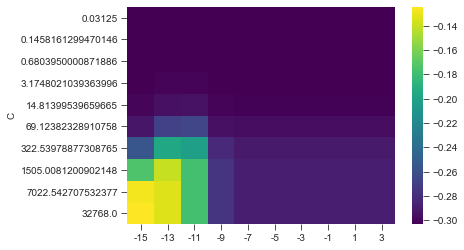

In [68]:
pivot = df.loc[df['kernel'] == 'rbf', ['mean', 'C', 'gamma']].pivot('C', 'gamma')
pivot.columns = np.arange(-15, 5, 2)
display(pivot)

sns.heatmap(pivot, cmap='viridis')

<AxesSubplot:ylabel='C'>

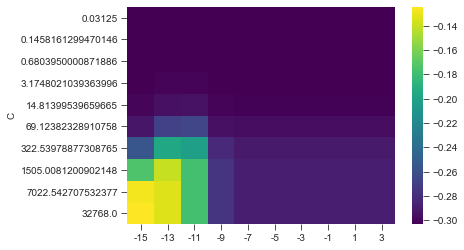

In [46]:
results['RBG']['bg'].groupby('kernel').mean()  # kernel C  bg  ogtt  RBG  FBG  all

,mean,C
kernel,,
linear,-0.296067,0.747273
poly,-0.288324,0.747273
rbf,-0.810622,0.747273


In [14]:
model = SVR()
param_grid = {'kernel': ['rbf', 'linear'],
              'C': [0.1, 0.4, 0.6, 0.7, 0.8, 0.85, 0.9, 0.93, 0.96, 0.98, 1.0]}
gs = GridSearchCV(
    model, 
    param_grid, 
    cv=10,
    scoring='neg_mean_absolute_percentage_error',
    n_jobs=7,
    )
gs_result_all_ogtt = gs.fit(X_all, y_ogtt)

# summarize results
print("Best: %f using %s" % (gs_result_all_ogtt.best_score_, gs_result_all_ogtt.best_params_))
means = gs_result_all_ogtt.cv_results_['mean_test_score']
stds = gs_result_all_ogtt.cv_results_['std_test_score']
params = gs_result_all_ogtt.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.118269 using {'C': 0.9, 'kernel': 'linear'}
-0.307511 (0.077348) with: {'C': 0.1, 'kernel': 'rbf'}
-0.180080 (0.052390) with: {'C': 0.1, 'kernel': 'linear'}
-0.307386 (0.077298) with: {'C': 0.4, 'kernel': 'rbf'}
-0.131720 (0.039868) with: {'C': 0.4, 'kernel': 'linear'}
-0.307303 (0.077265) with: {'C': 0.6, 'kernel': 'rbf'}
-0.122239 (0.044749) with: {'C': 0.6, 'kernel': 'linear'}
-0.307261 (0.077249) with: {'C': 0.7, 'kernel': 'rbf'}
-0.120474 (0.046193) with: {'C': 0.7, 'kernel': 'linear'}
-0.307218 (0.077233) with: {'C': 0.8, 'kernel': 'rbf'}
-0.118752 (0.046856) with: {'C': 0.8, 'kernel': 'linear'}
-0.307197 (0.077225) with: {'C': 0.85, 'kernel': 'rbf'}
-0.118371 (0.047042) with: {'C': 0.85, 'kernel': 'linear'}
-0.307175 (0.077217) with: {'C': 0.9, 'kernel': 'rbf'}
-0.118269 (0.047122) with: {'C': 0.9, 'kernel': 'linear'}
-0.307162 (0.077213) with: {'C': 0.93, 'kernel': 'rbf'}
-0.118276 (0.047168) with: {'C': 0.93, 'kernel': 'linear'}
-0.307149 (0.077208) with: {'C': 0.96, 

In [11]:
gs_result_all_ogtt

GridSearchCV(cv=10, estimator=SVR(), n_jobs=7,
             param_grid={'C': [0.1, 0.4, 0.6, 0.7, 0.8, 0.85, 0.9, 0.93, 0.96,
                               0.98, 1.0],
                         'kernel': ['rbf', 'linear']})